*Let's import all the things*

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import xml.etree.ElementTree as ET
import xmltodict

import geopandas as gpd

import matplotlib.pyplot as plt

import pysal as ps
import shapely
from shapely.geometry import Point
import unicodedata


print('Libraries imported.')

C:\Users\Alexey\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


Libraries imported.


*Define useful functions*

In [2]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [3]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [4]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

*Get geoJSON from Seattle Open Data Program*

In [5]:
!wget -q -O seattle_data.json http://data-seattlecitygis.opendata.arcgis.com/datasets/b76cdd45f7b54f2a96c5e97f2dda3408_2.geojson

print('Data downloaded!')

Data downloaded!


SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = c:/progra~1/wget/etc/wgetrc


In [6]:
urlz = 'http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz1h38gdvze2z_3z9zt&state=wa&city=seattle&childtype=neighborhood'

results = requests.get(urlz)


In [57]:
zillow = open("zillow.xml", "w")
zillow.write(results.text)
zillow.close()

In [58]:
seattle_data = gpd.read_file('seattle_data.json')

In [59]:
with open('zillow.xml', 'r') as f:
    data = xmltodict.parse(f.read())['RegionChildren:regionchildren']['response']['list']['region']

df = pd.DataFrame(data)
df.head()
#['Response']['Region']['Region']['Name']

,id,name,zindex,url,latitude,longitude
0,250206,Capitol Hill,"{'@currency': 'USD', '#text': '415600'}",http://www.zillow.com/local-info/WA-Seattle/Ca...,47.62622,-122.315979
1,272001,University District,"{'@currency': 'USD', '#text': '514200'}",http://www.zillow.com/local-info/WA-Seattle/Un...,47.66073,-122.305045
2,271990,Magnolia,"{'@currency': 'USD', '#text': '662000'}",http://www.zillow.com/local-info/WA-Seattle/Ma...,47.650943,-122.409136
3,250788,Greenwood,"{'@currency': 'USD', '#text': '421400'}",http://www.zillow.com/local-info/WA-Seattle/Gr...,47.694211,-122.355289
4,252248,Wallingford,"{'@currency': 'USD', '#text': '608500'}",http://www.zillow.com/local-info/WA-Seattle/Wa...,47.658763,-122.334464


In [60]:
dff = df['zindex'].apply(pd.Series)
df['Median Price'] = dff['#text']
df.drop(['zindex','id','url'],axis=1, inplace=True)


In [61]:
seattle_data.drop(['OBJECTID','PERIMETER','L_HOOD', 'L_HOODID','SYMBOL','SYMBOL2','AREA','HOODS_','HOODS_ID','SHAPE_Length','SHAPE_Area'], axis=1, inplace=True)
seattle_data = seattle_data[seattle_data.S_HOOD != 'OOO']

In [62]:
print(seattle_data.shape)
print(df.shape)

(93, 2)
(102, 4)


In [63]:
result = pd.merge(df, seattle_data, left_on='name', right_on='S_HOOD', how='right')

In [64]:
result['Median Price'] = result['Median Price'].astype(float)
meanprice = result['Median Price'].mean(skipna=True)
result.fillna(0, inplace=True)
result.name = result.name.astype(str)
meanprice = int(meanprice)
result.replace(0, meanprice, inplace=True)
result['Median Price'] = result['Median Price'].astype(int)

In [65]:
result.insert(0, 'Neighborhood', result['S_HOOD'])


In [66]:
result = gpd.GeoDataFrame(result, geometry='geometry')
result.crs = {'init' :'epsg:4326'}
result['Latitude'] = result.centroid.y
result['Longitude'] = result.centroid.x
result.drop('latitude', axis=1, inplace=True)
result.drop('longitude', axis=1, inplace=True)
result.drop('S_HOOD', axis=1, inplace=True)
result.drop('name', axis=1, inplace=True)
result.replace(' ', 'Unknown', inplace=True)

In [67]:
neighborhood_latitude = result.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = result.loc[0, 'Longitude'] # neighborhood longitude value

In [68]:
CLIENT_ID = 'ILRX2S1MUNNNJKFGMDG03YWZDBGBWDUUTYGS2100MTQOKEWS' # your Foursquare ID
CLIENT_SECRET = '3IMHIY1MAM130M0Y5ZBTEAJ02DQZJRDPQK5RYHPQ45YWM0UE' # your Foursquare Secret
LIMIT = 250
radius = 500
VERSION = '20180605' # Foursquare API version
urlf = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&ll={},{}&radius={}&limit={}&v={}'.format(
        CLIENT_ID,
        CLIENT_SECRET,
        neighborhood_latitude,
        neighborhood_longitude,
        radius,
        LIMIT,
        VERSION)

*Creating the map*

In [137]:
seattle_map = folium.Map(location=[47.60,-122.33], zoom_start=12, tiles='OpenStreetMap')
seattle_map

In [138]:
folium.Choropleth(geo_data = result.to_json(),
    data=result,
    columns=['Neighborhood','Median Price'],
    key_on='feature.properties.Neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Seattle Neighborhoods'
).add_to(seattle_map)

seattle_map.save("neighborhoods.html")


In [72]:
seattle_venues = getNearbyVenues(names=result['Neighborhood'],
                                   latitudes=result['Latitude'],
                                   longitudes=result['Longitude'],
                                   radius=radius)

University District
Greenwood
Wallingford
Fremont
North Beacon Hill
First Hill
Ravenna
Maple Leaf
Minor
North Queen Anne
Belltown
Phinney Ridge
Green Lake
Bitter Lake
Haller Lake
Columbia City
Broadview
West Woodland
Olympic Hills
Brighton
East Queen Anne
Loyal Heights
High Point
South Lake Union
Highland Park
Wedgwood
North College Park
West Queen Anne
Genesee
Gatewood
Dunlap
South Delridge
Alki
Pinehurst
Lower Queen Anne
Cedar Park
Fairmount Park
Whittier Heights
Victory Heights
Rainier Beach
Sunset Hill
Bryant
Matthews Beach
Roxhill
South Beacon Hill
Arbor Heights
Broadway
Interbay
Fauntleroy
Roosevelt
Leschi
Seaview
Holly Park
Madrona
Laurelhurst
Mann
Crown Hill
View Ridge
Westlake
North Delridge
Rainier View
Eastlake
Meadowbrook
Montlake
South Park
Riverview
International District
Lawton Park
Industrial District
Industrial District
Briarcliff
Madison Park
Seward Park
Georgetown
Windermere
Portage Bay
Atlantic
Yesler Terrace
Harbor Island
Sand Point
Pioneer Square
Adams
Southeast M

In [153]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")
seattle_onehot.drop('Neighborhood', axis=1, inplace=True)

# add neighborhood column back to dataframe
seattle_onehot.insert(0,'Neighborhood', seattle_venues['Neighborhood'])

seattle_onehot.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,Airport,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Theater,Comedy Club,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Herbs & Spices Store,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Sculpture,Outdoor Supply Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Pub,Public Art,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Rock Club,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Track,Trade School,Trail,Train Station,Tunnel,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Zoo Exhibit
0,University District,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [154]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()

In [157]:
seattle_grouped.shape

(89, 279)

In [158]:
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adams----
                venue  freq
0  Mexican Restaurant  0.06
1      Ice Cream Shop  0.05
2                 Bar  0.05
3        Cocktail Bar  0.05
4        Burger Joint  0.05


----Alki----
            venue  freq
0           Trail  0.17
1         Brewery  0.17
2  Scenic Lookout  0.17
3      Playground  0.17
4            Park  0.17


----Arbor Heights----
               venue  freq
0          BBQ Joint   0.5
1        Music Venue   0.5
2                ATM   0.0
3             Office   0.0
4  Outdoor Sculpture   0.0


----Atlantic----
            venue  freq
0     Bus Station  0.17
1      Skate Park  0.08
2    Dance Studio  0.08
3            Park  0.08
4  Rental Service  0.08


----Belltown----
              venue  freq
0               Bar  0.08
1       Coffee Shop  0.07
2            Bakery  0.05
3  Sushi Restaurant  0.05
4       Pizza Place  0.04


----Bitter Lake----
                  venue  freq
0       Automotive Shop  0.08
1       Thai Restaurant  0.08
2  Marijuana Dispensary

                  venue  freq
0  Marijuana Dispensary   0.2
1                  Park   0.1
2      Insurance Office   0.1
3             Pet Store   0.1
4                  Lake   0.1


----Mid-Beacon Hill----
                venue  freq
0           BBQ Joint   0.2
1         Bus Station   0.2
2      Scenic Lookout   0.2
3   Martial Arts Dojo   0.2
4  Light Rail Station   0.2


----Minor----
         venue  freq
0   Food Truck  0.27
1  Coffee Shop  0.27
2      Theater  0.09
3   Playground  0.09
4     Bus Stop  0.09


----Montlake----
                venue  freq
0            Bus Stop  0.26
1       Grocery Store  0.11
2         Coffee Shop  0.11
3  Salon / Barbershop  0.11
4           Bike Shop  0.05


----Mount Baker----
             venue  freq
0             Park  0.25
1  Harbor / Marina  0.25
2        Pet Store  0.25
3      Pizza Place  0.25
4  Other Nightlife  0.00


----North Admiral----
                venue  freq
0         Coffee Shop  0.08
1                 Pub  0.06
2       Grocery S

In [159]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Mexican Restaurant,Burger Joint,Bar,Ice Cream Shop,Cocktail Bar,Coffee Shop,Bakery,Vietnamese Restaurant,Sushi Restaurant,Italian Restaurant
1,Alki,Boarding House,Trail,Scenic Lookout,Playground,Park,Brewery,Zoo Exhibit,Ethiopian Restaurant,Dry Cleaner,Dumpling Restaurant
2,Arbor Heights,BBQ Joint,Music Venue,Zoo Exhibit,Falafel Restaurant,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market
3,Atlantic,Bus Station,Café,Park,Skate Park,Trail,Tunnel,Dance Studio,Residential Building (Apartment / Condo),Rental Service,South American Restaurant
4,Belltown,Bar,Coffee Shop,Sushi Restaurant,Bakery,Pizza Place,Cocktail Bar,Breakfast Spot,Hotel,New American Restaurant,Movie Theater


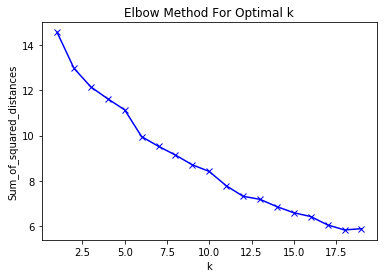

In [160]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(seattle_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [161]:
kclusters = 10

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [162]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = result

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,Neighborhood,Median Price,geometry,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University District,514200,POLYGON ((-122.2928690095396 47.66123668496127...,47.659728,-122.308346,1.0,Coffee Shop,Thai Restaurant,Sandwich Place,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Café,Korean Restaurant,Chinese Restaurant
1,Greenwood,421400,POLYGON ((-122.3607722911877 47.70512071459287...,47.694175,-122.355316,1.0,Coffee Shop,Mexican Restaurant,Bookstore,Bar,Playground,Hot Dog Joint,Sports Bar,Brewery,Diner,Karaoke Bar
2,Wallingford,608500,POLYGON ((-122.3473075666623 47.66500529130313...,47.659995,-122.333068,1.0,Coffee Shop,Japanese Restaurant,Thai Restaurant,Pharmacy,Bakery,Bar,Pub,Bookstore,Ice Cream Shop,Burger Joint
3,Fremont,505400,POLYGON ((-122.3608026702445 47.66690756290661...,47.656823,-122.352789,1.0,American Restaurant,Coffee Shop,Park,Convenience Store,Cocktail Bar,Mexican Restaurant,Bookstore,Motel,Board Shop,Burger Joint
4,North Beacon Hill,400900,POLYGON ((-122.3115289998971 47.59587650985339...,47.578363,-122.309774,1.0,Mexican Restaurant,Café,Coffee Shop,Dance Studio,Sandwich Place,Bakery,Gas Station,Food Truck,Taco Place,Bus Station


In [163]:
seattle_merged.dropna(inplace=True)

In [164]:
seattle_merged['Cluster Labels'] = seattle_merged['Cluster Labels'].astype(int)

In [165]:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(seattle_map)
       
seattle_map.save("clusters.html")

In [167]:
for i in range(kclusters):
    print('Label color: ', rainbow[i-1])
    print('Number of neighborhoods in cluster: ', seattle_merged['Neighborhood'].loc[seattle_merged['Cluster Labels'] == i].count())
    display(seattle_merged.loc[seattle_merged['Cluster Labels'] == i, seattle_merged.columns[[0] + [1] + list(range(6, seattle_merged.shape[1]))]])



Label color:  #ff0000
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,View Ridge,656000,Park,Event Space,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Zoo Exhibit,Dog Run


Label color:  #8000ff
Number of neighborhoods in cluster:  70


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,University District,514200,Coffee Shop,Thai Restaurant,Sandwich Place,Vietnamese Restaurant,Asian Restaurant,Japanese Restaurant,Mediterranean Restaurant,Café,Korean Restaurant,Chinese Restaurant
1,Greenwood,421400,Coffee Shop,Mexican Restaurant,Bookstore,Bar,Playground,Hot Dog Joint,Sports Bar,Brewery,Diner,Karaoke Bar
2,Wallingford,608500,Coffee Shop,Japanese Restaurant,Thai Restaurant,Pharmacy,Bakery,Bar,Pub,Bookstore,Ice Cream Shop,Burger Joint
3,Fremont,505400,American Restaurant,Coffee Shop,Park,Convenience Store,Cocktail Bar,Mexican Restaurant,Bookstore,Motel,Board Shop,Burger Joint
4,North Beacon Hill,400900,Mexican Restaurant,Café,Coffee Shop,Dance Studio,Sandwich Place,Bakery,Gas Station,Food Truck,Taco Place,Bus Station
5,First Hill,296000,Sandwich Place,Bar,Coffee Shop,Hotel,Brewery,Bakery,Asian Restaurant,Italian Restaurant,Pizza Place,Speakeasy
6,Ravenna,573300,Mediterranean Restaurant,Coffee Shop,Sushi Restaurant,New American Restaurant,Bagel Shop,Southern / Soul Food Restaurant,Bakery,Greek Restaurant,Grocery Store,Bookstore
7,Maple Leaf,468500,Video Store,Gym / Fitness Center,Convenience Store,Bus Station,Arts & Crafts Store,Coffee Shop,Pharmacy,Zoo Exhibit,Dry Cleaner,Dumpling Restaurant
8,Minor,450500,Coffee Shop,Food Truck,Bus Stop,Convenience Store,Theater,Playground,Soccer Stadium,Ethiopian Restaurant,Drugstore,Dry Cleaner
9,North Queen Anne,658000,ATM,Restaurant,Soccer Field,Tennis Court,Burger Joint,Bagel Shop,Sandwich Place,Café,Harbor / Marina,Cupcake Shop


Label color:  #4856fb
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,Briarcliff,488253,Bus Stop,Park,Scenic Lookout,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Zoo Exhibit


Label color:  #10a2f0
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
74,Windermere,967300,Auto Workshop,Beach,Zoo Exhibit,Farmers Market,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant


Label color:  #2adddd
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Olympic Hills,365200,Food Truck,Zoo Exhibit,Farmers Market,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Fast Food Restaurant


Label color:  #62fbc4
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Matthews Beach,556700,Gym,Zoo Exhibit,Dog Run,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant


Label color:  #9cfba4
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
65,Riverview,325300,Bakery,Playground,Zoo Exhibit,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant


Label color:  #d4dd80
Number of neighborhoods in cluster:  3


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,East Queen Anne,667300,Park,Playground,Zoo Exhibit,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant
22,High Point,322800,Playground,Park,Garden,Vietnamese Restaurant,Zoo Exhibit,Ethiopian Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store
67,Lawton Park,488253,Park,Massage Studio,Playground,Zoo Exhibit,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant


Label color:  #ffa256
Number of neighborhoods in cluster:  1


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
72,Seward Park,590400,Arts & Crafts Store,Burger Joint,Beach,Zoo Exhibit,Falafel Restaurant,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market


Label color:  #ff562c
Number of neighborhoods in cluster:  11


,Neighborhood,Median Price,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Green Lake,573500,Park,Lake,Trail,Playground,Theater,Bed & Breakfast,Beach,Ethiopian Restaurant,Drugstore,Dry Cleaner
26,North College Park,388200,Park,Coffee Shop,Community College,Fish & Chips Shop,Filipino Restaurant,Fish Market,Field,Fast Food Restaurant,Farmers Market,Dog Run
29,Gatewood,446800,Park,Coffee Shop,Massage Studio,Zoo Exhibit,Falafel Restaurant,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
33,Pinehurst,365100,Park,Convenience Store,Pizza Place,Garden,Basketball Court,Bus Stop,Rock Club,Coffee Shop,Moving Target,Farmers Market
48,Fauntleroy,535900,Park,Pilates Studio,Dance Studio,Bakery,Market,American Restaurant,Lawyer,Fast Food Restaurant,Field,Filipino Restaurant
50,Leschi,624600,Park,Pizza Place,Pet Store,Playground,American Restaurant,Grocery Store,Electronics Store,Donut Shop,Drugstore,Dry Cleaner
64,South Park,253300,Park,Brewery,Library,Italian Restaurant,Bar,Deli / Bodega,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
88,Mount Baker,488253,Park,Pet Store,Harbor / Marina,Pizza Place,Electronics Store,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant
90,Unknown,488253,Park,Beach,Restaurant,History Museum,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
91,Unknown,488253,Park,Beach,Restaurant,History Museum,Event Space,Drugstore,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant
